In [3]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import regularizers

In [4]:
IMAGE_DIR = Path('./butterflies/train')
DESC_CSV = Path('./butterflies/Training_set.csv')

## Load dataset

In [5]:
desc_df = pd.read_csv(DESC_CSV)
len(desc_df)

6499

In [6]:
desc_df.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


## Plot data

In [9]:
def plot_distribution(class_counts):
    plt.figure(figsize=(10, 8))
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title('Distribution of Butterfly Classes')
    plt.xlabel('Butterfly Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

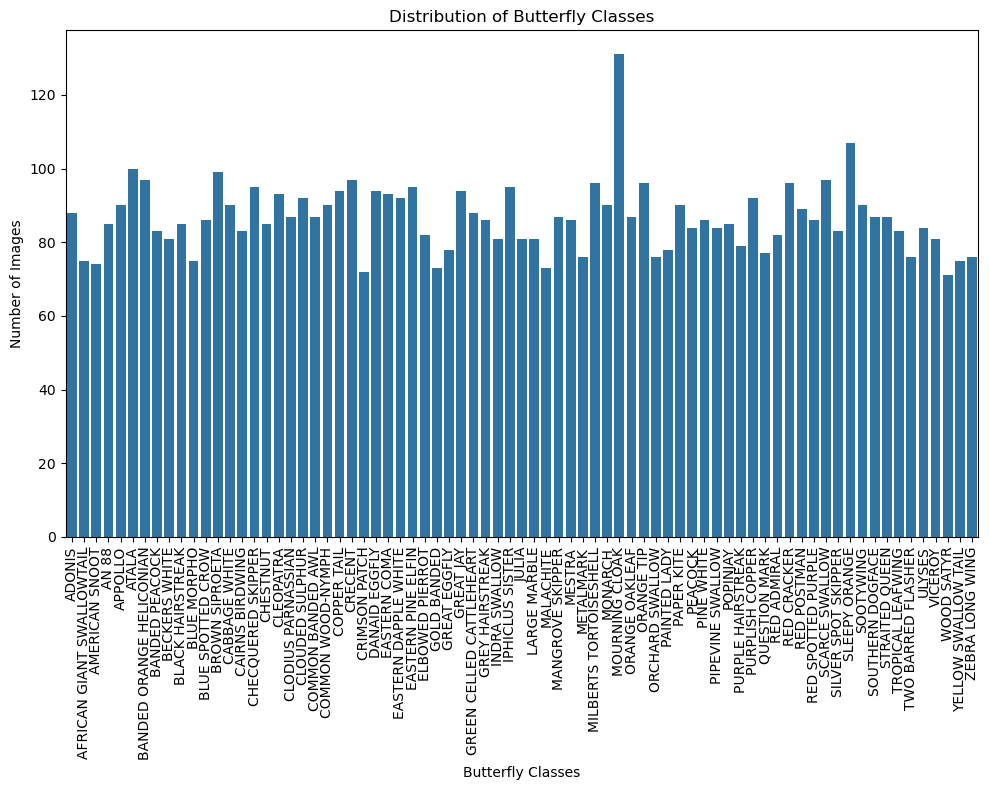

In [10]:
class_counts = desc_df['label'].value_counts().sort_index()
plot_distribution(class_counts)

## Only take a subset of the classes

In [12]:
keep_class_number = 15

top_classes = class_counts.sort_values(ascending=False).head(keep_class_number).index

df_filtered = desc_df[desc_df['label'].isin(top_classes)]

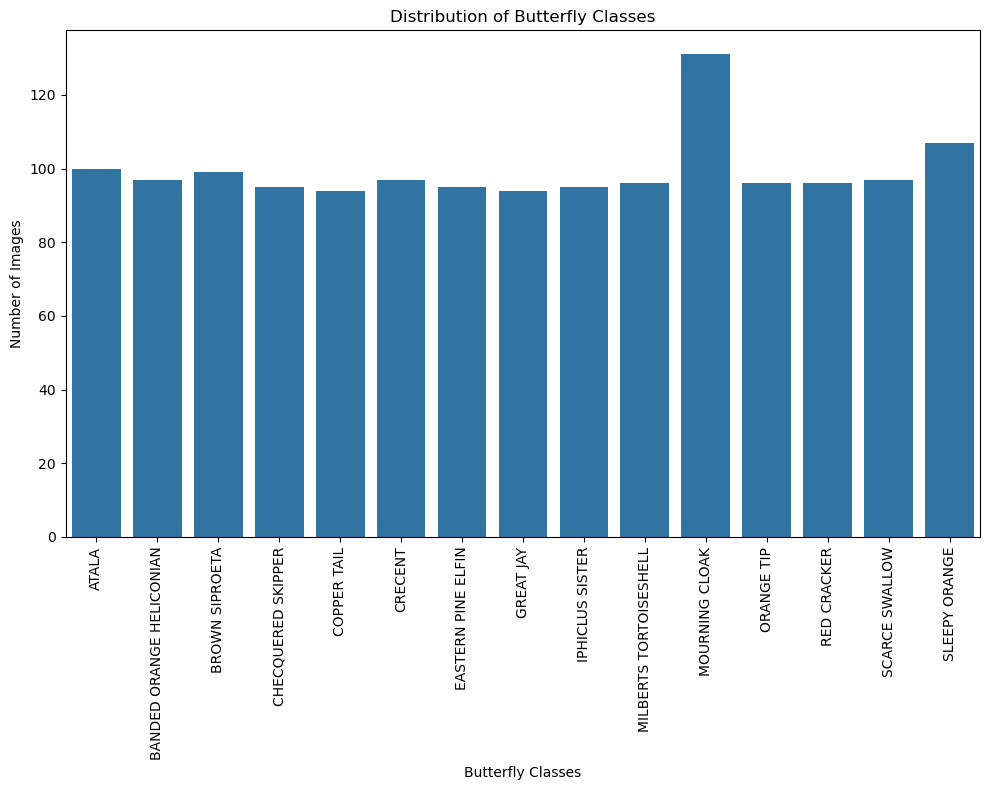

In [13]:
class_counts_f = df_filtered['label'].value_counts().sort_index()
plot_distribution(class_counts_f)

## Undersample to balance the distribution

In [14]:
min_count = df_filtered['label'].value_counts().min()

df_balanced = df_filtered.groupby('label', group_keys=False).apply(lambda x: x.sample(min_count, random_state=42))

df_balanced = df_balanced.reset_index(drop=True)

print(df_balanced['label'].value_counts())

label
ATALA                       94
BANDED ORANGE HELICONIAN    94
BROWN SIPROETA              94
CHECQUERED SKIPPER          94
COPPER TAIL                 94
CRECENT                     94
EASTERN PINE ELFIN          94
GREAT JAY                   94
IPHICLUS SISTER             94
MILBERTS TORTOISESHELL      94
MOURNING CLOAK              94
ORANGE TIP                  94
RED CRACKER                 94
SCARCE SWALLOW              94
SLEEPY ORANGE               94
Name: count, dtype: int64


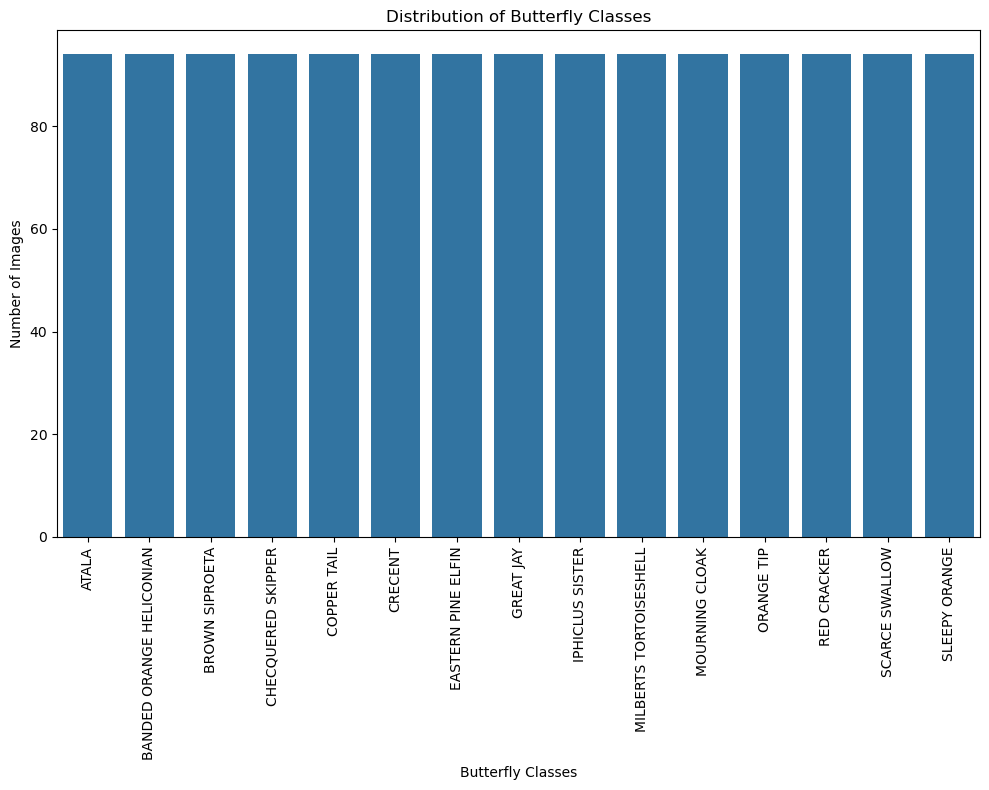

In [15]:
class_counts_b = df_balanced['label'].value_counts().sort_index()
plot_distribution(class_counts_b)

## Show examples

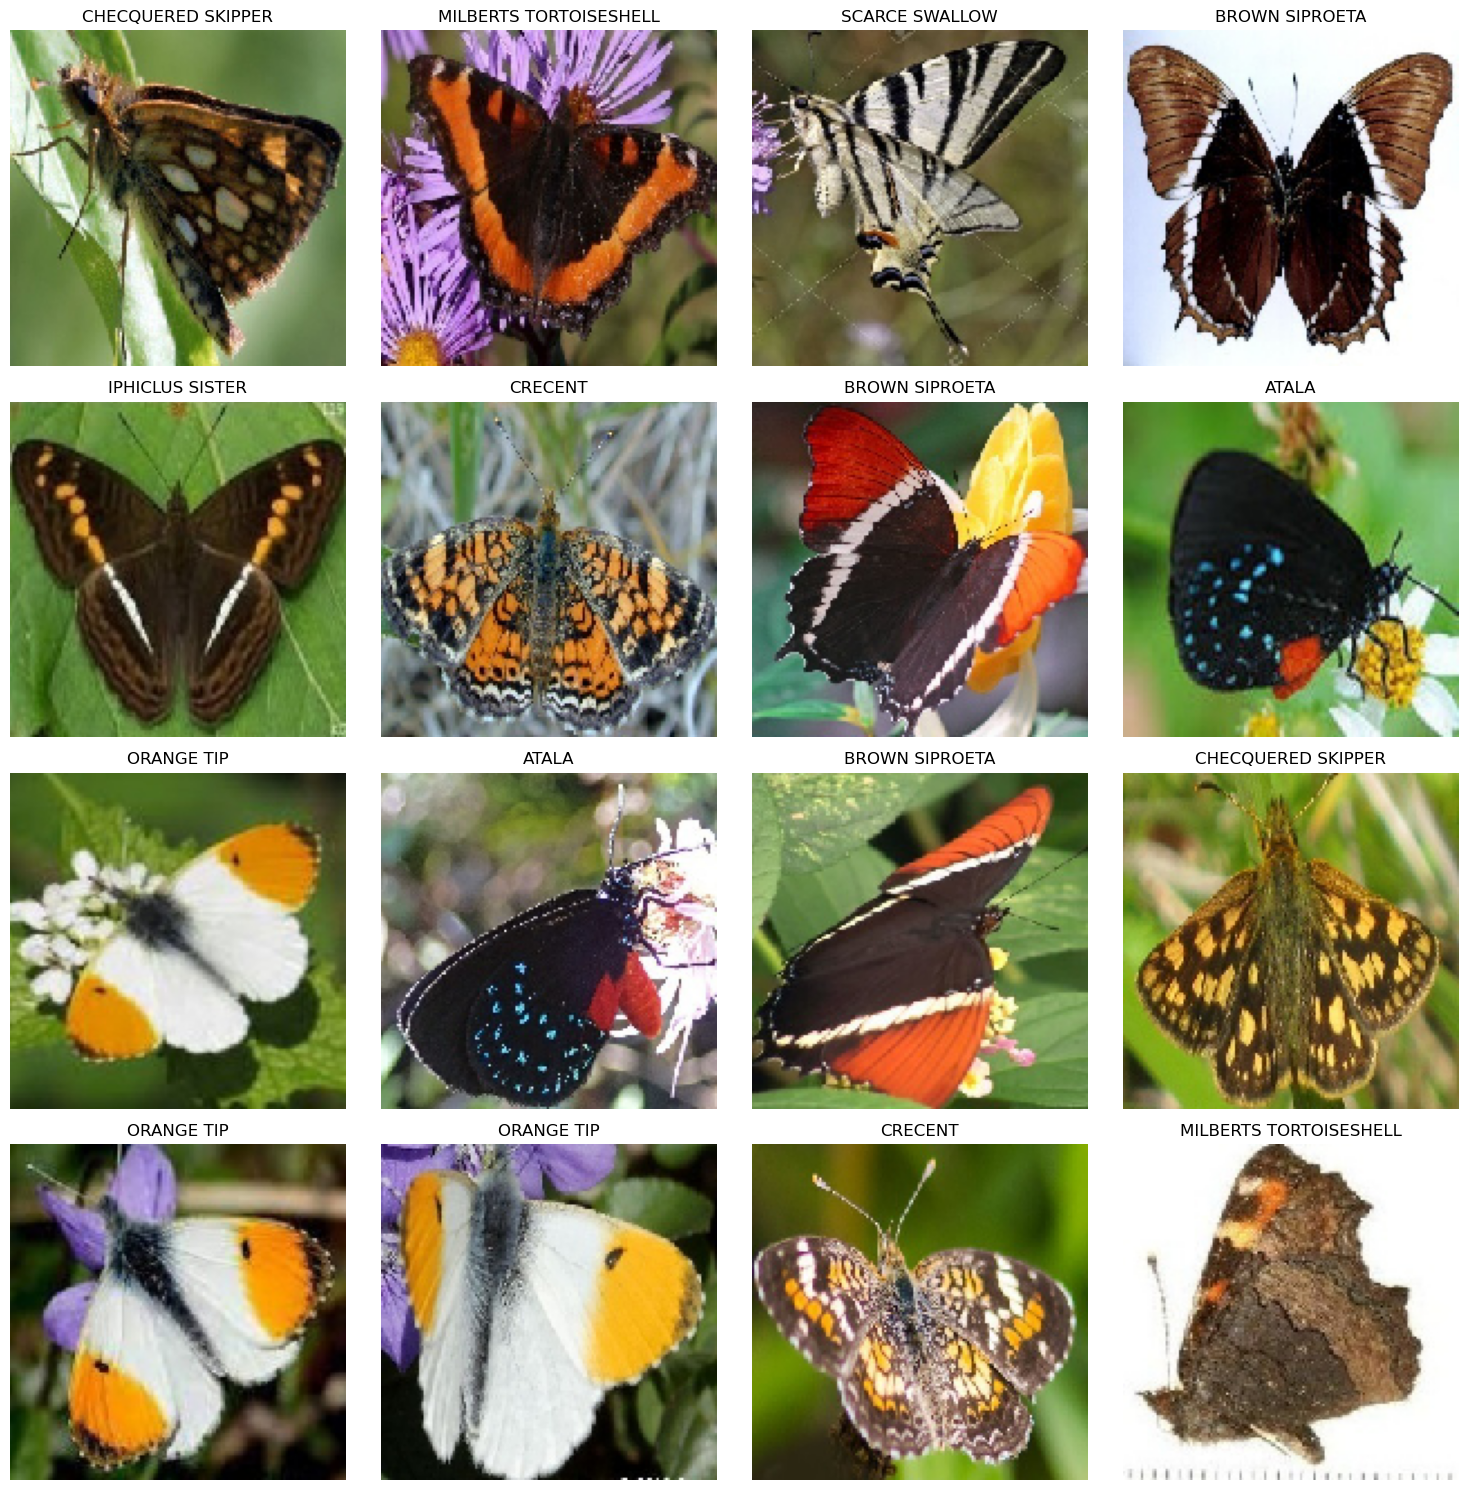

In [16]:
sample_images = df_balanced.sample(16, random_state=42)

fig, axes = plt.subplots(4, 4, figsize=(15, 15))

for i, (index, row) in enumerate(sample_images.iterrows()):
    img_path = IMAGE_DIR / row['filename']
    img = load_img(img_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255.0  # Normalize the image
    
    ax = axes[i // 4, i % 4]
    ax.imshow(img_array)
    ax.set_title(row['label'])
    ax.axis('off')

plt.tight_layout()
plt.show()


## Split to train and test sets

In [17]:
train, test = train_test_split(df_balanced, test_size=0.2, random_state=42)
train.size, test.size

(2256, 564)

## Preprocess images

In [63]:
import tensorflow as tf
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    #preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    #preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [64]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train,
    directory=IMAGE_DIR,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=8,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train,
    directory=IMAGE_DIR,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=8,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test,
    directory=IMAGE_DIR,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=8,
    shuffle=False
)

Found 903 validated image filenames belonging to 15 classes.
Found 225 validated image filenames belonging to 15 classes.
Found 282 validated image filenames belonging to 15 classes.


## Build model

In [87]:
import tensorflow as tf
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(keep_class_number, activation='softmax'))


print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 109, 109, 32)      18464     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 52, 52, 16)        4624      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 24, 24, 16)      

## Compile model

In [88]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Fit model

In [89]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
113/113 [==============================] - 25s 213ms/step - loss: 2.7096 - accuracy: 0.0819 - val_loss: 2.7056 - val_accuracy: 0.0444
Epoch 2/50
113/113 [==============================] - 26s 230ms/step - loss: 2.6291 - accuracy: 0.1019 - val_loss: 2.4972 - val_accuracy: 0.1600
Epoch 3/50
113/113 [==============================] - 27s 241ms/step - loss: 2.4157 - accuracy: 0.1849 - val_loss: 2.4128 - val_accuracy: 0.2222
Epoch 4/50
113/113 [==============================] - 27s 239ms/step - loss: 2.2006 - accuracy: 0.2315 - val_loss: 2.0918 - val_accuracy: 0.2933
Epoch 5/50
113/113 [==============================] - 27s 235ms/step - loss: 2.0032 - accuracy: 0.3223 - val_loss: 1.9717 - val_accuracy: 0.3156
Epoch 6/50
113/113 [==============================] - 26s 231ms/step - loss: 1.8151 - accuracy: 0.4031 - val_loss: 1.8678 - val_accuracy: 0.4267
Epoch 7/50
113/113 [==============================] - 26s 231ms/step - loss: 1.7328 - accuracy: 0.4042 - val_loss: 1.6905 - val_ac

## Evaluate model

In [90]:
loss, accuracy = model.evaluate(test_images, verbose=1)
print(f"Test loss: {loss:.2f}")
print("Test accuracy: {:.2f}%".format(accuracy * 100))

36/36 [==============================] - 2s 53ms/step - loss: 0.8584 - accuracy: 0.7234
Test loss: 0.86
Test accuracy: 72.34%


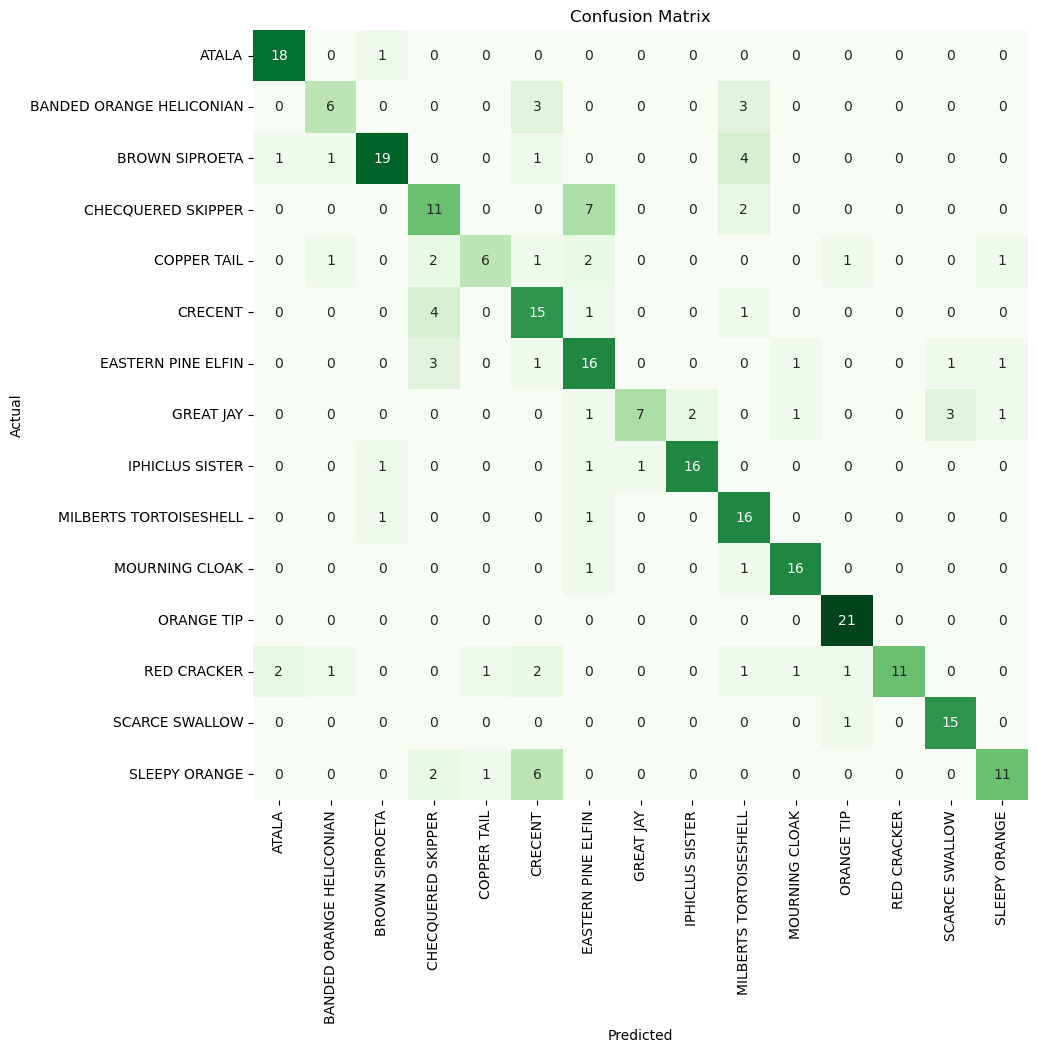

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Greens', cbar=False)
plt.xticks(ticks=np.arange(keep_class_number) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(keep_class_number) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [93]:
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                           precision    recall  f1-score   support

                   ATALA       0.86      0.95      0.90        19
BANDED ORANGE HELICONIAN       0.67      0.50      0.57        12
          BROWN SIPROETA       0.86      0.73      0.79        26
      CHECQUERED SKIPPER       0.50      0.55      0.52        20
             COPPER TAIL       0.75      0.43      0.55        14
                 CRECENT       0.52      0.71      0.60        21
      EASTERN PINE ELFIN       0.53      0.70      0.60        23
               GREAT JAY       0.88      0.47      0.61        15
         IPHICLUS SISTER       0.89      0.84      0.86        19
  MILBERTS TORTOISESHELL       0.57      0.89      0.70        18
          MOURNING CLOAK       0.84      0.89      0.86        18
              ORANGE TIP       0.88      1.00      0.93        21
             RED CRACKER       1.00      0.55      0.71        20
          SCARCE SWALLOW    

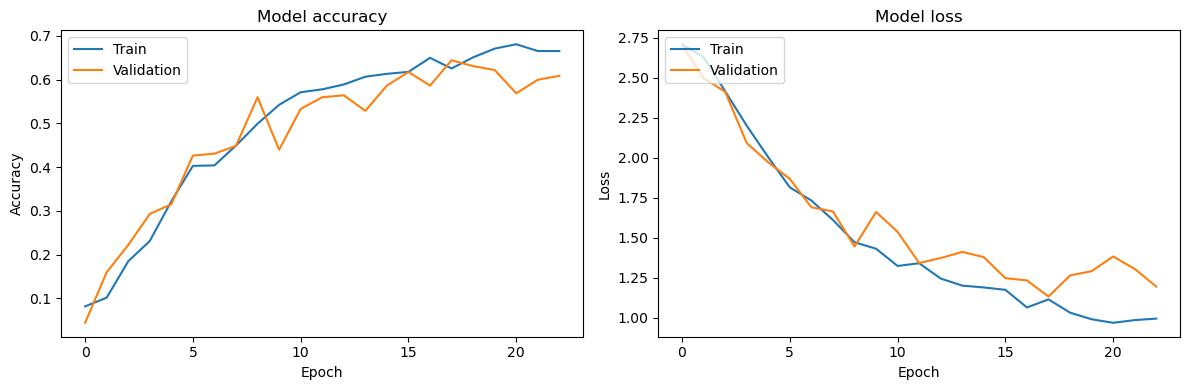

In [94]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()